In [12]:
import os
from itertools import product
from joblib import Parallel, delayed

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests, linear_regression
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from numba import njit, jit
from joblib import Parallel, delayed

In [14]:
sess = u.load_single_day(ctrl_mice[0],3)


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}


In [16]:
sess.trial_matrices['bin_edges']
bin_edges = np.arange(sess.trial_matrices['bin_edges'][0], sess.trial_matrices['bin_edges'][-1],.5)

In [25]:
bin_edges = bin_edges = np.arange(sess.trial_matrices['bin_edges'][0], sess.trial_matrices['bin_edges'][-1],.5).tolist()
tstarts, tstops = sess.trial_start_inds.tolist(), sess.teleport_inds.tolist()
n_perms = 1000
cell_ts = sess.timeseries['spks']


@njit
def get_mask(pos, left, right):
    return np.multiply(np.greater(pos,left),np.less_equal(pos,right))
    

def make_trial_mat(pos, cell_ts, tstarts, tstops, bin_edges):
    tmat = np.nan*np.zeros(( len(tstarts), len(bin_edges)-1, cell_ts.shape[0]))
    for t, (start, stop) in enumerate(zip(tstarts, tstops)):
        pos_vec = pos[start:stop]
        cell_ts_t = cell_ts[:,start:stop]
        for b, (left, right) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
            mask = get_mask(pos_vec, left, right)
            tmat[t,b,:] = cell_ts_t[:,mask].mean(axis=-1)
    return tmat
    
    
def run_trial_mat_perms(pos, cell_ts, tstarts, tstops, bin_edges, n_perms):
    # pos_perm = np.nan*np.zeros((n_perms, pos.shape[0]))
    
    def trial_loop(p):
        rng = np.random.default_rng(p)
        pos_perm =  np.nan*np.zeros( pos.shape)
        tmat_perm = np.nan*np.zeros(( len(tstarts), len(bin_edges)-1, cell_ts.shape[0]))
        # print(tmat_perm.shape)
        for t, (start, stop) in enumerate(zip(tstarts, tstops)):
            pos_vec = np.roll(pos[start:stop], rng.integers(stop-start))
            cell_ts_t = cell_ts[:,start:stop]
            # print(cell_ts_t.shape)
            for b, (left, right) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
                # mask = (pos_vec>left)*(pos_vec<=right)
                mask = get_mask(pos_vec, left, right)
                if mask.sum()>0:
                    
                # pos_vec[mask] = b
                    tmat_perm[t,b,:] = np.nanmean(cell_ts_t[:,mask], axis=-1)
                # tmat_perm[t,b,:] = get_bin_avg(cell_ts_t, pos_vec, left,right)
                
            # print(pos_vec.shape)
            pos_perm[start:stop] = pos_vec
        return tmat_perm.mean(axis=0)
        
    # pos_perm_list =[trial_loop(p) for p in range(n_perms)]
    pos_perm_list = Parallel(n_jobs=-1)(delayed(trial_loop)(p) for p in range(n_perms))
    # for p in range(n_perms):
        
    return np.array(pos_perm_list)



In [26]:
pos_perm_avg_trial_mats = run_trial_mat_perms(sess.timeseries['t'].ravel(), 
                              sess.timeseries['spks'],
                              tstarts, tstops, bin_edges, n_perms)

In [27]:
pos = np.arange(10)
np.percentile(pos,99.9)

8.991000000000001

In [39]:
tmat = make_trial_mat(sess.timeseries['t'].ravel(), 
                     sess.timeseries['spks_norm'],
                     tstarts, tstops, bin_edges)

/tmp/ipykernel_379611/3658203211.py:19: RuntimeWarning: Mean of empty slice.
  tmat[t,b,:] = cell_ts_t[:,mask].mean(axis=-1)


In [40]:
rng.integers(5)

2

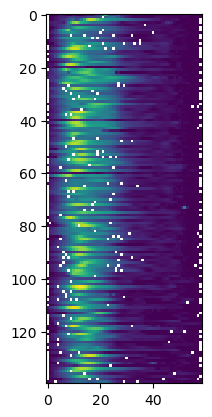

In [41]:
fig, ax = plt.subplots()
ax.imshow(tmat[:,:,3],interpolation='none')

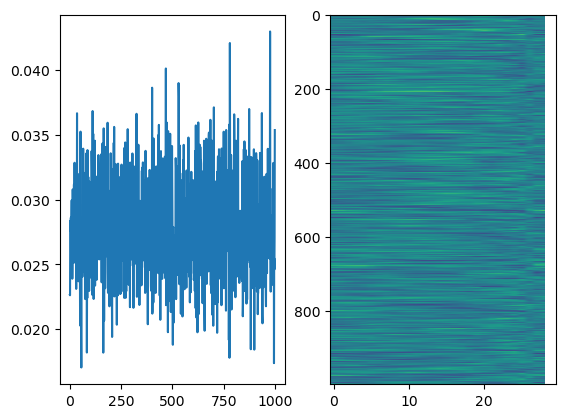

In [23]:
fig,ax = plt.subplots(1,2)
perm_mat = pos_perm_avg_trial_mats[:,:,3]
ax[0].plot(perm_mat[:,0])
# print(np.nanmin(mat),np.nanpercentile(mat))
ax[1].imshow(pos_perm_avg_trial_mats[:,:,3],aspect='auto')

In [35]:
n_bins = bin_edges.shape[0]-1
n_cells = sess.timeseries['spks'].shape[0]
tmat = np.nan*np.zeros((n_perms, n_cells, n_bins))
for pos in pos_perm_list:
    
    for start, stop in zip(tstarts, tstops):
        arr = sess.timeseries['spks'][:,start:stop]
        for b in range(n_bins):
            
            

(1000, 27495)

In [ ]:
@njit
def get_bin_mask(vec, left,right):
    return vec

In [40]:
p = 0 
tmat = np.zeros((sess.trial_start_inds.shape[0], sess.timeseries['spks'].shape[0], bin_edges.shape[0]-1))
tseries = sess.timeseries['spks']
for start,stop in zip(sess.trial_start_inds, sess.teleport_inds):
    

(140, 1048, 60)

In [35]:
# start,stop
# sess.timeseries['t'][0,start:stop]
np.roll(sess.timeseries['t'][0,start:stop], rng.integers(stop-start))

array([38.54674515, 38.72283764, 38.89582123, 39.06757407, 39.19429534,
       39.37271111, 39.52156764, 39.68531351, 39.85363178, 39.96753379,
       40.21371154, 40.42749506, 40.6619411 , 40.90058853, 41.13521682,
       41.45891756, 41.72396308, 41.98149892, 13.48466593, 13.68528919,
       13.93486607, 14.15508293, 14.47081728, 14.83155871, 15.03448933,
       15.61498846, 16.0304355 , 16.47455005, 17.00484521, 17.473658  ,
       17.94205607, 18.33601815, 18.86132289, 19.31407528, 19.64913169,
       20.23546041, 20.58529938, 21.15416074, 21.59002912, 21.99963621,
       22.39283371, 22.71668877, 23.19887037, 23.56924423, 23.92369273,
       24.33788583, 24.69201595, 25.11547543, 25.50112432, 25.88096074,
       26.26059994, 26.59871837, 26.98764736, 27.2522332 , 27.70089559,
       27.97704735, 28.36807678, 28.76767985, 29.07365246, 29.37833814,
       29.61864877, 29.84137   , 30.10496556, 30.31514295, 30.58350988,
       30.80923018, 31.03124407, 31.24804728, 31.42354981, 31.65